# SCS 3546 Week 10 - Speech and Music - Recognition and Synthesis

## Learning Objectives

- Use tools to extract features from audio
- Experiment with tools for analyzing and synthesizing human speech
- Explore the history of computer composition
- Work with neural nets for generating speech, sound and music

In [ ]:
# Import necessary modules and dependencies   

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

### Sound

- Sound is nothing more than ripples in the air: alternating bands of higher and lower air pressure that move from the source of the sound to your ears.
- If we record the air pressure at a point in space between a speaker and a listener and plot it as a function of time we would see a repeating wave-like pattern.  This is exactly what a microphone does: it is a tiny pressure gauge that records the variation in air pressure at a point in space.  The microphone in a digital recorder or computer **records the fluctuations in air pressure as a number** every few hundred thousandths of a second, creating a time series.  A time series like this is often referred to as a **signal**.


In [ ]:
# First, install librosa before running the next cell
#!pip install librosa

#### Example: spectrogram

In [ ]:
# Let's generate a plot then spectrogram for the Star Wars Imperial March

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# Use IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import tensorflow as tf

In [ ]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

y, sr = librosa.load(testing_wav_file_name) # y is the signal and sr is the sample rate (22050 for this file)
IPython.display.Audio(y, rate=sr)

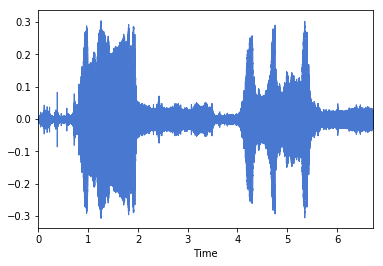

In [ ]:
librosa.display.waveplot(y)

In [ ]:
len(y)

148422

In [ ]:
len(y)/39

3805.6923076923076

- The diagam above shows a plot of the signal i.e. a representation of the variation of air pressure around the microphone over time.
- We can easily load this into a Pandas Series.

In [ ]:
from pandas import Series

march = Series(y)
march[20000:20500]

20000    0.106785
20001    0.156794
20002    0.189815
20003    0.205955
20004    0.200859
           ...   
20495    0.126607
20496    0.190115
20497    0.237176
20498    0.266222
20499    0.267126
Length: 500, dtype: float32

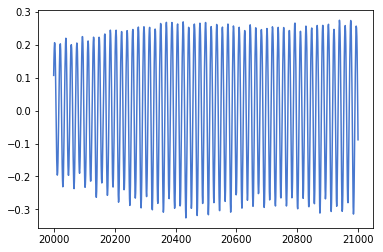

In [ ]:
# Let's zoom in on a few hundredths of a second
march[20000:21000].plot()

### The Sound Spectrum

- An alternative way of thinking about **sound is as a progression of mixtures of different frequencies of air vibration**.  We perceive frequency as pitch: a vibration at twice the frequency of another we would hear as a sound an octave higher.
- When different frequencies are related by whole number ratios we usually perceive it as being a note at the lowest frequency in the mix, but having a different colour (timbre) than if we had just heard the lowest frequency tone alone.
- We can tell an oboe from a clarinet for example because their sounds have different combinations of these higher frequencies (called *overtones*) making them sound qualitatively different.
- The range of frequencies we can hear runs from about 20 cycles per second (also known as Hertz) up to about 20,000.
- We can visualize the amount of energy at each frequency over time using a diagram called a *spectrogram*.
- A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time

## Sound Files

### Audio Files

- Audio files contain a time series along with some metadata such as the sample rate.  The sample rate is the number of pressure readings taken per second.  The readings are relative to air at rest so they have a mean of about zero.
- Each data point (observation of air pressure) is called a *sample* (although the word sample is sometimes used differently by musicans to mean an entire recording of a single note played by an instrument).
- Audio files can be monophonic or stereo. A stereo file has two observations per point in time recorded by two different mics.
- An important result in information theory is the Nyquist-Shannon sampling rate which says that to reliably capture a frequency in a signal you need to sample it at least twice as often as that frequency.  Compact disks as a result have 44,100 samples per second (approx. 2 x the 20,000/second humans can hear).
- 8,000 samples per second is sufficient for clearly recognizable human speech (this is what the phone system uses) because the human voice can't reach frequencies much higher than that.

#### Example: Audio data import

In [ ]:
# Import the Speech Commands dataset
# The original dataset consists of over 105,000 WAV audio files of people saying thirty different words
# https://arxiv.org/abs/1804.03209

data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

# check the data 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'yes' 'up' 'no' 'down' 'left' 'stop']


In [ ]:
# Extract the audio files into a list and shuffle it
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of examples: 8000
Number of examples per label: 1000


In [ ]:
print('Example file tensor:', filenames[0])

Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/62ef962d_nohash_0.wav', shape=(), dtype=string)


In [ ]:
'''Reading audio files and their labels'''

def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

In [ ]:
# Take in the filename of the WAV file and output a tuple containing the audio and labels
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

test = filenames[1:6400]

# Build our data set to extract the audio-label pairs
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(test)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


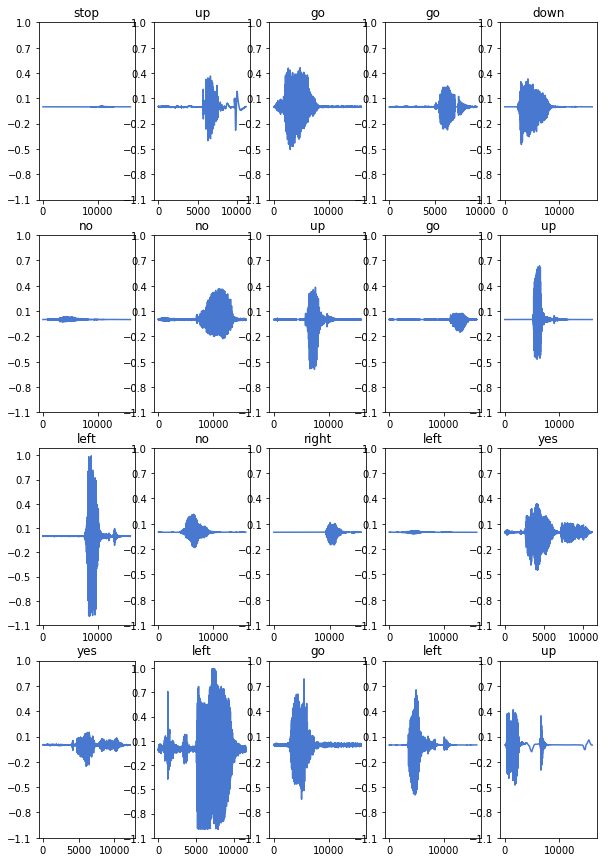

In [ ]:
# examine a few audio waveforms 
rows = 4
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 15))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.1, 1.2, 0.3))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### MIDI Files

- **MIDI (Musical Instrument Digital Interface)** is a **technical standard** that describes a **communications protocol**, digital interface, and electrical connectors that **connect a wide variety of electronic musical instruments, computers, and related audio devices for playing, editing and recording music**.
- MIDI carries event messages, data that specify the instructions for music, including a **note's notation, pitch, velocity (which is heard typically as loudness or softness of volume), vibrato, panning to the right or left of stereo, and clock signals (which set tempo)**. When a musician plays a MIDI instrument, all of the key presses, button presses, knob turns and slider changes are converted into MIDI data.
- MIDI is a protocol that was **developed in the 1980's for communicating notes to be played from an electronic keyboard to a synthesizer**
- A MIDI file stores **a sequence of piano key numbers that were pressed by the keyboard player**.  It does not contain any audio.
- For each played key it stores when the key was pressed (relative to the recording start time), how fast it was pressed down, and when it was released.  MIDI files can store some additional information allowing for non-standard tunings and what kind of instrument is expected for each part but does not exactly specify what the instruments should sound like when the file is played.  They can't be used to record speech for example.  For that you need an audio file.
- Early music composition systems (such as EMI we'll discuss shortly) generated MIDI files as output.  As we will also see soon, state of the art composition and synthesis systems attempt to generate audio directly rather than MIDI.

## Speech Recognition

### Human Speech

### Strategies for Recognizing Speech

- Our challenge is to convert these streams of numbers to a stream of words (text)
- The task becomes much easier if we can first translate the stream of pressure variations to a stream of frequencies that vary much more slowly and are far easier to recognize
- We can recognize them by matching against templates for known phonemes

### Speech Recognition Using Neural Nets

- Recurrent NN's are a natural choice for signal processing
- NN's have sufficient capacity to also learn about useful information between phonemes
- We call a snippet of speech we want to recognize as a unit an utterance
- An utterance can start at any time and has a definite structure through time so we would like to put a timeframe around it
- But identifying the beginning of a frame, particularly in a noisy environment, can be challenging
- So we must be continually starting new frames, running in parallel, and discard the ones that don't seem to form a coherent utterance

## Music Recognition

- Music recognition systems work by fingerprinting audio files
- They do this by measuring the most prominent frequencies in particular ranges per unit time (a compressed spectrogram)
- When presented a new music snippet they take its fingerprint then do a search for it within the fingerprints of all the songs in the service's library

### Example of Audio Recognition 

In [ ]:
''' Simple audio recognition '''

# take a small sample of the files 
test_files = filenames[:100]

#Reading audio files and their labels
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

# The label for each WAV file
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

# To take in the filename of the WAV file and output a tuple containing the audio and labels
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# Build our data set to extract the audio-label pairs
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(test_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


### Example on how to check an audio waveforms with its corresponding labels

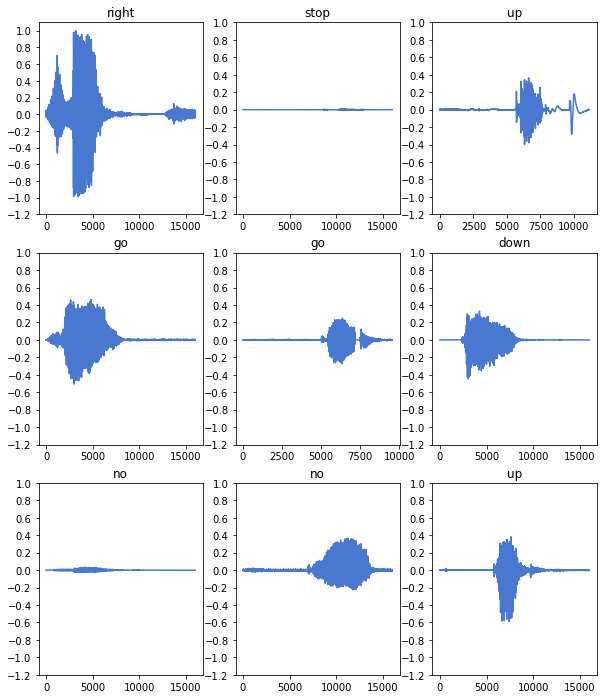

In [ ]:
# Check a mine a few audio waveforms with their corresponding labels
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Example: How to convert the waveform into a spectrogram

In [ ]:
''' Convert the waveform into a spectrogram  '''
# Let's  shows frequency changes over time and can be represented as a 2D image

def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram


In [ ]:
# Compare the waveform, the spectrogram and the actual audio of one example from the dataset
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


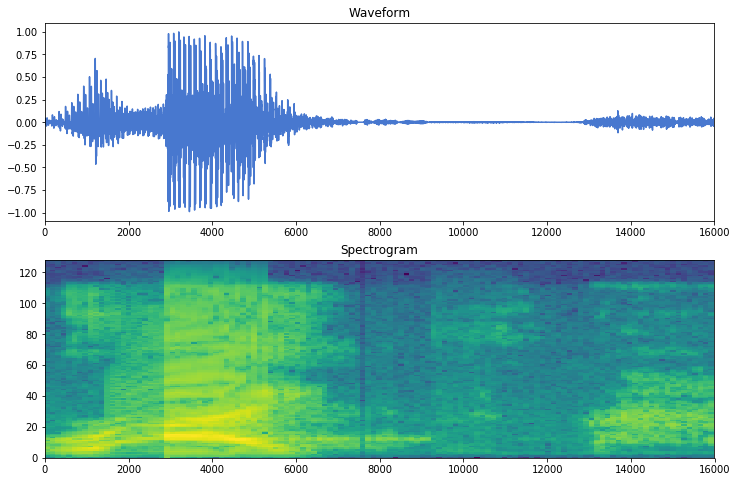

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

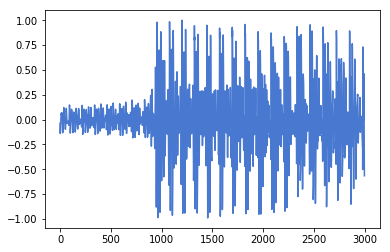

In [ ]:
import matplotlib.pyplot as plt
# Plot a section of the waveform.
plt.plot(waveform.numpy().flatten()[2000:5000])
plt.show()

### Example: How to transform the waveform dataset 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:861: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


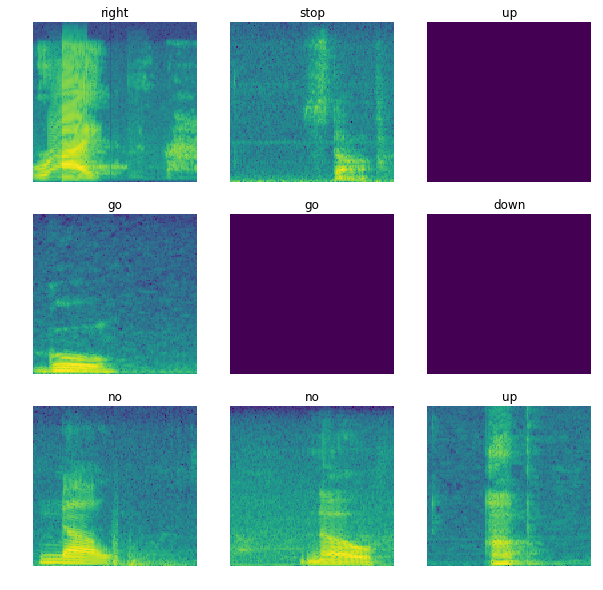

In [ ]:
# transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE) 

# Examine the spectrogram "images" for different samples of the dataset
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Algorithmic Music Synthesis

### History

- The idea of algorithmic music has been around for a long time
- It was popular in Mozart’s time to play the “Dice Game” where a die was used to select the notes of a motive (recurring theme/figure/ditty) or first notes of a composition

#### Illiac Suite

- The first computer-composed material was in 1957: the Illiac Suite (named after the ILLIAC computer) used several computer-generated  parts https://en.wikipedia.org/wiki/Illiac_Suite
- [here](https://www.youtube.com/watch?v=n0njBFLQSk8&index=12&list=RDCgG1HipAayU) is an example played by real orchestra

#### Cybernetic Composer

- Charles Ames’ Cybernetic Composer (1992) often produced fairly musical results generating music in several styles by following the rules of the genre
- Not a machine learning example though; just random  generation constrained to a grammar
- e.g. http://charlesames.net/cybernetic-composer/Latin%20Jazz%201.mp3 


#### David Cope

- Cope was a Professor of Music at the University of California at Santa Cruz (retired now)
- https://en.wikipedia.org/wiki/David_Cope 
- His primary research area was use of AI for music composition and has been the most successful at it so far
- Started work on Experiments in Musical Intelligence (EMI, pronounced Emmy and he refers to it as “her”) in the early 1980’s
- EMI uses classical AI techniques (no neural nets)

#### EMI and Emily Howell

- His original idea was to code the rules of basic part-writing
- Produced correct but styleless music so he abandoned the approach and started a new program (EMI) based on the idea of “recombinance”: learning from a body of actual works of a composer then recombining them in new but correct ways by learning the voice leading (chord-to-chord progression) rules of the input body of work
- He wanted to ultimately use the system to synthesize new works in his own style to get past a writer’s block
- Started with Bach chorales which he hand-input as MIDI wasn’t quite available yet
- The resulting works were wandering with no overall structure, unbalanced phrases, usually in a single key, no sense of repetition and development we expect
- He then enhanced the analysis (learning) phase of EMI to recognize specific musical structures and idioms (in today’s parlance he hand-crafted a set of features)
- Builds a database of these features (we’d now call it a model) that were used to generate new works by combining the individually correct parts in valid ways
- Subsequent versions of the program through to today have added increasingly elaborate feature recognition and modeling
- [Examples (played by a real orchestra)](https://www.youtube.com/watch?v=CgG1HipAayU&list=RDCgG1HipAayU&t=128)
- He called his successor to EMI "Emily Howell"

#### Neural Nets for Composition

- Dominik Hörnel and Wolfram Menzel conducted some experiments in 1998 using neural nets to attempt to compose works in the style of the Renaissance and Baroque

### Representing Music

- “Common Practice Period” (see https://en.wikipedia.org/wiki/Common_practice_period) music follows many strict rules about how each of the different notes of each chord can move relative to their predecessors and each other; randomly generated notes or chords will quickly give themselves away to a listener as not following the rules we have all subliminally learned from listening to music previously
- Depending on the type of the musical composition there is also a lot of large scale structure that must be respected (see https://en.wikipedia.org/wiki/Symphony and https://en.wikipedia.org/wiki/Sonata)

<center><img src="https://drive.google.com/uc?id=1jy0fzyxv3If3afx5fIzi0jLolMa9qoen" ></center>

A symphony has typically 3 oto 4 movements that all follow a specific structure (called sonata form):
- Introduction: An opening that may or may not foreshadow what is to come
- Exposition: Introduces a musical theme (motive) that will be the raw material for the next phase
- Development: Builds on the motive by altering it in a number of ways
- Recapitulation: The exposition is repeated (not identically) but represents a return to the familiar after a journey of exploration
- Coda: An optional embellishment at the end

The material is almost always organized into phrases that are no longer than the time a person could sing without taking a breath

### SampleRNN

- Whereas WaveNet is a convolutional net, SampleRNN is an RNN
- It is a tiered model where each layer effectively runs at a different sample rate and so each layer learns features on a different timescale, from per sample to over several seconds
- Since higher layers run at lower rates they are computationally less intensive (whereas WaveNet layers all run at the full sample rate)
- Here is an example: http://deepsound.io/mp3/samplernn_first/piano.mp3


In [ ]:
import keras 
# A simple RNN with just a single layer
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

### Project Magenta

- Magenta is a Google-supported research project to use neural nets for music composition and sound synthesis
- It was started by members of the Google Brain team and now has many other contributors
- https://nsynthsuper.withgoogle.com/
- They are also building new interfaces (instruments) to control their models and open-sourcing the plans: https://github.com/googlecreativelab/open-nsynth-super

### NSynth

- Rather than generating compositions, [NSynth (Neural Synthesizer)](https://magenta.tensorflow.org/nsynth) is an RNN that learns to generate new sounds from examples it has heard
- Uses a WaveNet-like RNN to synthesize new instruments that combine features of instruments it was trained on

### MusicVAE

- State of the art is Magenta [MusicVAE (Variational Autoencoder)](https://magenta.tensorflow.org/music-vae)
- It is a hierarchical RNN
- Can be thought of as a music “compression algorithm”; encodes a piece in a relatively small vector than can be used to reconstruct it or variations on it by varying the vector slightly
- So far less impressive than EMI but learns features rather than having them hand-crafted so more general
- https://codepen.io/adarob/full/gzwJZL/ 
- But months old as of 2018 vs. decades of work put into EMI
- Example at https://magenta.tensorflow.org/music-vae
- https://magenta.tensorflow.org/multitrack
- During training finds a vector of learned features that could conceivably someday allow one to do things like Bach – fugue + sonata to generate a sonata in Bach style
- Currently learns a model of an entire single piece and learns a sequence of sequences to get past RNN’s tendency to focus on recent structure and forget overall or past structure 
- Currently learns 3 parts (drum, bass, melody) as separate streams
- Trained using MIDI file inputs
- Main demo currently is interpolation between sequences: https://experiments.withgoogle.com/ai/beat-blender/view/


<center><img src="https://drive.google.com/uc?id=11L-Zeu1razhqSAhFmlU8cWTRUZN-Gpm4" ></center>

The above diagram shows notes entering the system and passing through an encoder which discovers a compressed form for the input which is encoded in a vector.  The vector can then be decoded to generate a sequence of notes very similar to those input.  By exposing the autoencoder to a variety of input sequences it learns a compact representation for the style of sequences it has been exposed to.

## Speech Synthesis

- Speech synthesis is a far simpler problem, although difficult to make truly natural-sounding
- These systems take phonetic spellings as input and play a stream of the spoken phonemes out
- The phonetic spellings can be directly input, looked up in a dictionary, or generated from ordinary words using a set of rules
- Acceptable robo-speech can be producing with simple technology not requiring a neural net: simply play high quality recordings of each phoneme in order (called Concatenative Text-to-Speech)
- It's more common to use a vocoder: an encoder which use hand-crafted features to extract a simple representation of the harmonic content from recorded examples of speech which then acts as a speech synthesizer when run in the other direction (called Parametric TTS)
- Research is underway on using deep NN autocoders to select better features than we would hand-craft in the hope of creating better speech synthesizers

### WaveNet

- WaveNet is a deep generative speech (and music) synthesis model developed by Google DeepMind

<center><img src="https://drive.google.com/uc?id=1GmcPbVDdYWrFZUVw7yZ3H7inOAXj7qD8" ></center>

The above diagram shows the relative quality scores assigned by human listeners to the best concatenative and parametric sytems vs. WaveNet and actual recordings.  WaveNet is a significant improvement over previous techniques.

<img src="https://lh3.googleusercontent.com/Zy5xK_i2F8sNH5tFtRa0SjbLp_CU7QwzS2iB5nf2ijIf_OYm-Q5D0SgoW9SmfbDF97tNEF7CmxaL-o6oLC8sGIrJ5HxWNk79dL1r7Rc=w1440-rw-v1">

[Source:[Talking Machines](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio)]

#### Example: WaveNet

In [ ]:
# generated sample data using the generate_time_series()
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# create a training set, a validation set, and a test set
n_steps=50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
# To compute the MSE over the output at the last time step
from tensorflow import keras 
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
''' A simplified WaveNet (Sequential model) '''

# CONV1D
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 [==============================] - 4s 15ms/step - loss: 0.0659 - last_time_step_mse: 0.0559 - val_loss: 0.0359 - val_last_time_step_mse: 0.0235
Epoch 2/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0319 - last_time_step_mse: 0.0194 - val_loss: 0.0289 - val_last_time_step_mse: 0.0164
Epoch 3/10
219/219 [==============================] - 3s 13ms/step - loss: 0.0279 - last_time_step_mse: 0.0158 - val_loss: 0.0267 - val_last_time_step_mse: 0.0151
Epoch 4/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0261 - last_time_step_mse: 0.0143 - val_loss: 0.0257 - val_last_time_step_mse: 0.0136
Epoch 5/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0251 - last_time_step_mse: 0.0134 - val_loss: 0.0244 - val_last_time_step_mse: 0.0124
Epoch 6/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0244 - last_time_step_mse: 0.0128 - val_loss: 0.0243 - val_last_time_step_mse: 0.0124
Epoch 7/10
219/219 [==

## Resources
- https://medium.com/@saxenauts/speech-synthesis-techniques-using-deep-neural-networks-38699e943861
- http://greenteapress.com/wp/think-dsp/
- https://github.com/AllenDowney/ThinkDSP
- https://musicinformationretrieval.com/
- https://librosa.github.io/
- https://github.com/tyiannak/pyAudioAnalysis
- https://deepmind.com/blog/wavenet-generative-model-raw-audio/
- https://www.audacityteam.org/
- http://deepsound.io/
- http://www.gitxiv.com/posts/kQhs4N6rRohXDcp89/samplernn-an-unconditional-end-to-end-neural-audio
- https://magenta.tensorflow.org/
- https://github.com/ybayle/awesome-deep-learning-music
- https://research.mozilla.org/machine-learning
- https://github.com/robmsmt/KerasDeepSpeech
- https://github.com/ShankHarinath/DeepSpeech2-Keras
- [TimbreTron](https://www.youtube.com/watch?v=YQAupr7JxNY)


- [Speech To Text Demo](https://dictation.io/)
- [Cocktail party effect](https://en.wikipedia.org/wiki/Cocktail_party_effect)
- [Blind Audio](https://cnl.salk.edu/~tewon/Blind/blind_audio.html)
- [Speech2Face](https://speech2face.github.io/)
- [Speech2Face Repo](https://github.com/imatge-upc/speech2face)
- [Spoken Language Processing](http://www.cs.toronto.edu/~frank/csc2518/)
- [Revealing Invisible Changes In The World](https://www.youtube.com/watch?v=e9ASH8IBJ2U)
- [Video Magnification](http://people.csail.mit.edu/mrub/vidmag/#code)


- [Discrete Cosine Transformations](http://datagenetics.com/blog/november32012/index.html)
- [Speech Processing for Machine Learning](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)
- [Torch Audio](https://github.com/pytorch/audio)
- [Torch Audio Tutorial](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)


- [Speech Recognition — Deep Speech, CTC, Listen, Attend, and Spell](https://medium.com/@jonathan_hui/speech-recognition-deep-speech-ctc-listen-attend-and-spell-d05e940e9ed1)
- [End to End Models for speech recognition](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/lectures/cs224n-2017-lecture12.pdf)
- [Listen, Attend and Spell](https://arxiv.org/pdf/1508.01211.pdf)
- [End-to-End Models for Speech Processing](https://web.stanford.edu/class/cs224s/lectures/224s.17.lec8.pdf)
- [CS224S / LINGUIST285 - Spoken Language Processing](https://web.stanford.edu/class/cs224s/syllabus.html)
- [Correction of Automatic Speech Recognition with Transformer Sequence-to-sequence Model](https://arxiv.org/abs/1910.10697)
- [STREAMING AUTOMATIC SPEECH RECOGNITION WITH THE TRANSFORMER MODEL](https://arxiv.org/pdf/2001.02674.pdf)


- [Dice Game](https://mozart.vician.cz/)
- [Magenta Publication](https://ai.google/research/pubs/?collection=magenta)
- https://experiments.withgoogle.com/ai/sound-maker/view/
- [A Hierarchical Recurrent Neural Network for Symbolic Melody Generation](https://arxiv.org/pdf/1712.05274.pdf)
- [Music VAE](https://magenta.tensorflow.org/music-vae)
- [Transformers and Self-Attention For Generative Models
(guest lecture by Ashish Vaswani and Anna Huang)](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture14-transformers.pdf)
- [Music Transformer](https://magenta.tensorflow.org/music-transformer)
- [Generating Piano Music with Transformer](https://colab.research.google.com/notebooks/magenta/piano_transformer/piano_transformer.ipynb)
- [GANSynth](https://magenta.tensorflow.org/gansynth)



- [History of text-to-speech](http://research.spa.aalto.fi/publications/theses/lemmetty_mst/chap2.html)
- [Speech Synthesis Tutorial](http://research.spa.aalto.fi/publications/theses/lemmetty_mst/contents.html)
- [The Voder: 1939, the worlds first electronic voice synthesizer](https://www.youtube.com/watch?v=TsdOej_nC1M)
- [Dennis Klatt's development of speech synthesizers 1939-1985 voice demonstration](https://www.youtube.com/watch?v=huq2TSV99hI)
- [WaveNet: A generative model for raw audio](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio)
- [WaveNet Demo](https://cloud.google.com/text-to-speech)
- [Tacotron](https://google.github.io/tacotron/)
- [Tacotron2 implementation in PyTorch](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/)
- [Expressive Speech Synthesis](https://ai.googleblog.com/2018/03/expressive-speech-synthesis-with.html)


